In [50]:
import pandas as pd
import numpy as np

from unidecode import unidecode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read historical wheat data 
- for Argentina on municipality level
- from 1969-2022
- SOURCE: https://datosestimaciones.magyp.gob.ar/

In [51]:
df = (pd
      .read_csv("data/crop/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]

"""
"Campaña" is based on USDA marketing year defintion. Argentinian wheat season spans from June-Dec. 
The following paragraph from USDA from April 2023 indicates how the first year number (e.g. XXXX in XXXX/YY) is relevant for our crop forecasts.

Post estimates Argentine wheat production to rebound to 19.5 million metric tons (MMT) in marketing year (MY) 2023/24, 
resulting in wheat exports of 13.7 MMT (including wheat flour as its wheat equivalent). However after the severe drought in MY 2022/23, 
more rains are needed to recharge soil moisture profiles before the June planting window (from: https://www.fas.usda.gov/data/argentina-grain-and-feed-annual-9)
"""
df["year"] = df["year"].str[:4].astype(int)

#df = df.loc[df["year"] >= 1973].reset_index(drop=True) # because of SCM availability

df.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha]
0,1969,BUENOS AIRES,25 DE MAYO,42000,71400,1700
1,1970,BUENOS AIRES,25 DE MAYO,36000,54000,1500
2,1971,BUENOS AIRES,25 DE MAYO,30000,39000,1300
3,1972,BUENOS AIRES,25 DE MAYO,41000,73600,1795
4,1973,BUENOS AIRES,25 DE MAYO,6000,9000,1500


We filter by provinces with relevant production

In [52]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production cumsum [%]"] = np.round(100 * production_by_province["production [t]"] / df["production [t]"].sum()).cumsum()
production_by_province.head()

,province,production [t],production cumsum [%]
0,BUENOS AIRES,359294370,58.0
1,SANTA FE,99172351,74.0
2,CORDOBA,82460626,87.0
3,LA PAMPA,32333143,92.0
4,ENTRE RIOS,28815350,97.0


Buenos Aires, Santa Fe, Cordoba, Entre Rios, and La Pampa contribute most of Argentinian wheat production. We will only focus on these 5 provinces from now on. In addition, these are the provinces with similar soil and climate conditions (Espinal, Pampas).

In [53]:
df = df.loc[df["province"].isin(['BUENOS AIRES', 'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'SANTA FE'])].reset_index(drop=True)

Filter by municipalities with complete time series

In [54]:
df = df[df.groupby(["province", "municipality"])[['province', "municipality"]].transform('size') == len(df["year"].unique().tolist())].reset_index(drop=True)

subnational wheat yield series

In [55]:
df_subnational = df.copy()
df_subnational["province"] = df_subnational["province"].str.lower().apply(lambda x: unidecode(x))
df_subnational["municipality"] = df_subnational["municipality"].str.lower().apply(lambda x: unidecode(x))
df_subnational["name"] = df_subnational["province"] + " " + df_subnational["municipality"]
df_subnational = df_subnational[["year", "name", "harvested area [ha]", "yield [kg/ha]"]]

Now we need to aggregate to national level by year. Yield is weighted with harvested area.

In [56]:
def aggregate_yield(data):    
    df_national = data.copy()
    df_national["yield weighted"] = df_national["yield [kg/ha]"] * df["harvested area [ha]"]
    df_national = df_national.groupby("year").agg({"harvested area [ha]":"sum", "yield weighted":"sum"})
    df_national["yield [kg/ha]"] = df_national["yield weighted"] / df_national["harvested area [ha]"]

    df_national = df_national[["harvested area [ha]", "yield [kg/ha]"]].reset_index()
    return df_national

In [57]:
df_national = aggregate_yield(df)

In [58]:
df_national.head()

,year,harvested area [ha],yield [kg/ha]
0,1969,5058530,1361.123558
1,1970,3553500,1331.921649
2,1971,4171350,1266.672348
3,1972,4819200,1607.983856
4,1973,3824040,1666.552307


In [59]:
df_subnational.head()

,year,name,harvested area [ha],yield [kg/ha]
0,1969,buenos aires 25 de mayo,42000,1700
1,1970,buenos aires 25 de mayo,36000,1500
2,1971,buenos aires 25 de mayo,30000,1300
3,1972,buenos aires 25 de mayo,41000,1795
4,1973,buenos aires 25 de mayo,6000,1500


<Axes: xlabel='year'>

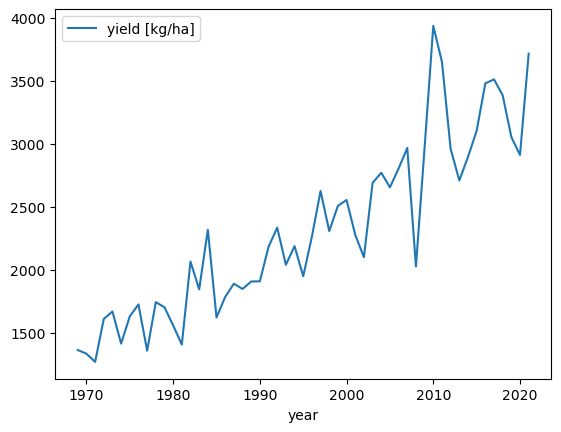

In [60]:
df_national.plot(x="year", y="yield [kg/ha]")

In [61]:
df_national.to_csv("data/crop/national_yield_with_trend.csv", index=False)
df_subnational.to_csv("data/crop/subnational_yield_with_trend.csv", index=False)